In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from scipy.stats import binom, beta, gamma, poisson, norm, expon, uniform

I really should have tried to factor out all the common code in here, but in the end just cut and paste. 

## Exercise 7.14 

Gamma Poisson model , $\lambda \sim Gamma(1,.01) $ and you observe one Poisson point, Y=4.   Use an indepence sampler

a) Which proposal model?  Exponential makes the most sense to me, with tunable parameter 'scale'.
b) Using that model , simulate 1000 lambda value, tune it 
c) exact posterior model is Gamma(5,1.01)
d) compare histogram to exact model

In [28]:
def SingleStep(scale, current):
    proposal = expon.rvs(scale = scale)
    proposal_plaus = gamma.pdf(proposal,1, scale =1.0/.01)*poisson.pmf(4,proposal)
    current_plaus = gamma.pdf(current,1, scale =1.0/.01)*poisson.pmf(4,current)
    alpha = min(1, proposal_plaus/current_plaus * expon.pdf(current, scale = scale)/ expon.pdf(proposal, scale = scale))
    next_step = np.random.choice(np.array([current,proposal]), p = np.array([1-alpha, alpha]))
    return (proposal, alpha, next_step)

In [29]:
np.array([1,2])

array([1, 2])

In [48]:
SingleStep(.3,3)

(0.5538978164603894, 3.9544852429361404e-06, 3.0)

In [51]:
def tour(n, start, scale):
    current = start
    res = [current]
    for i in range(0,n):
       (proposal, alpha, current) = SingleStep(scale, current)
       res.append(current)
    return res

Below I tried many values for the scale, settled on 10 but it was not super sensitive as long as in that order of magnitide

In [75]:
sim = tour(10000,1.0, 10.0)

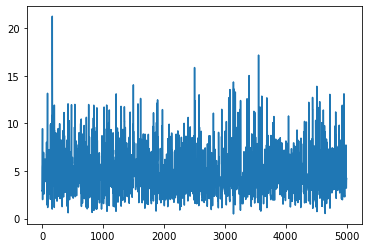

In [76]:
plt.plot(sim[5000:])

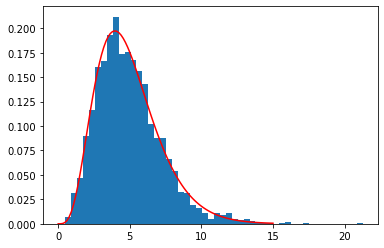

In [77]:
fig, ax = plt.subplots(1, 1)
x = np.linspace(0, 15, 100)
ax.hist(sim[5000:],density = True,bins=50)
ax.plot(x,gamma.pdf(x, 5, scale = (1/1.01)),'r-')

## Exercise 7.16

a) Question I chose was average high temperature in Arizona on august 15, just going back 5 years.  
b)  Prior model, i chose $\mu \sim N(90, 20)$   See below. I chose this because it puts very low probability on absurd values while still being not too informative.

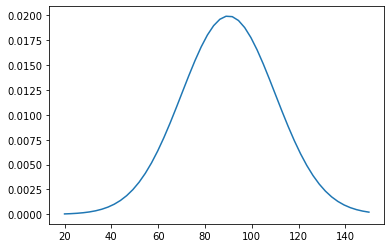

In [81]:
x = np.linspace(20,150,50)
plt.plot(x, norm.pdf(x, 90,20))

c)  Data collection! Temperature on Aug 15, for years  2018, 2019, 2020, 2021, 2022

In [82]:
temperature_data = [98,114,114,99,102]

In [83]:
np.std(temperature_data)

7.1442284397967

Since we need to specify sigma for the likelhood, i am going to to choose 7.1 as above (taking it ias fixed)
d) as a proposal model, i am going ot use a uniform model with width 'w'. 

In [85]:
 


def SingleStepN(w, current, data):
    proposal = uniform.rvs()*w*2 + current - w 
    proposal_plaus = norm.pdf(proposal,90, 20)*np.prod([norm.pdf(el,proposal, 7.1) for el in data])
    current_plaus = norm.pdf(current,90, 20)*np.prod([norm.pdf(el,current, 7.1) for el in data])
    alpha = min(1, proposal_plaus/current_plaus)
    next_step = np.random.choice(np.array([current,proposal]), p = np.array([1-alpha, alpha]))
    return (proposal, alpha, next_step)

In [87]:
def tourN(n, start, w, data):
    current = start
    res = [current]
    for i in range(0,n):
       (proposal, alpha, current) = SingleStepN(w, current,data)
       res.append(current)
    return res

In [102]:
sim = tourN(10000,100,10.,temperature_data)

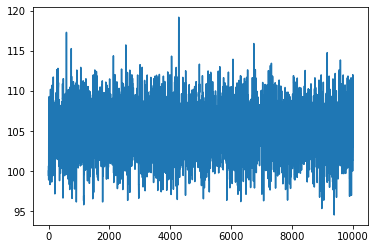

In [103]:
plt.plot(sim)

In [99]:
post_mean = (np.mean(temperature_data)*5*20**2 + 90*7.1**2 )/(5*20**2 +  7.1**2)
post_var = 20**2*7.1**2/(5*20**2 +  7.1**2)
print(f"Post mean {post_mean} , post std {np.sqrt(post_var)}")

Post mean 105.0213859667091 , post std 3.13594176202758


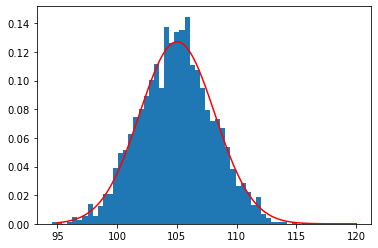

In [104]:
fig, ax = plt.subplots(1, 1)
x = np.linspace(95, 120, 100)
ax.hist(sim[5000:],density = True,bins=50)
ax.plot(x,norm.pdf(x, post_mean, np.sqrt(post_var)),'r-')

In [94]:
np.mean(sim)

105.01579407634689

In [95]:
np.std(sim)

3.1243082814140224